In [1]:

import warnings
from glob import glob 
import numpy as np # linear algebra
import seaborn as sns
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/all-datasets-of-buenos-aires/buenos-aires-real-estate-2.csv
/kaggle/input/all-datasets-of-buenos-aires/buenos-aires-real-estate-1.csv
/kaggle/input/all-datasets-of-buenos-aires/buenos-aires-real-estate-5.csv
/kaggle/input/all-datasets-of-buenos-aires/buenos-aires-real-estate-3.csv
/kaggle/input/all-datasets-of-buenos-aires/buenos-aires-real-estate-4.csv


In this project, I will be creating a model aimed at predicting `Buenos Aires` House Prices based on `Size`, `Location` and `Neighborhood`

`Prepare Data` is the first step

In [2]:
# First,I will create my wrangle function
def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    # Drop features with high null counts
    df.drop(columns = ["floor", "expenses"], inplace=True)
    
    # Drop low- and high-cardinality categorical variables
    df.drop(columns=["operation", "property_type", "currency", "properati_url"], inplace=True)
    
    # Drop leaky columns
    df.drop(columns=[
        "price",
        "price_aprox_local_currency",
        "price_per_m2",
        "price_usd_per_m2",
    ], inplace=True
           )
    
    # Drop columns with multicollinearity
    df.drop(columns=["surface_total_in_m2", "rooms"], inplace=True)
    
    return df

Use `glob` to create a list that contains the filenames for all the `Buenos Aires` real estate CSV files in the data directory. Assign this list to the variable name files.

In [3]:
files =glob("/kaggle/input/all-datasets-of-buenos-aires/buenos-aires-real-estate-*.csv")
files

['/kaggle/input/all-datasets-of-buenos-aires/buenos-aires-real-estate-2.csv',
 '/kaggle/input/all-datasets-of-buenos-aires/buenos-aires-real-estate-1.csv',
 '/kaggle/input/all-datasets-of-buenos-aires/buenos-aires-real-estate-5.csv',
 '/kaggle/input/all-datasets-of-buenos-aires/buenos-aires-real-estate-3.csv',
 '/kaggle/input/all-datasets-of-buenos-aires/buenos-aires-real-estate-4.csv']

In [4]:
# Check your work
assert len(files) == 5, f"`files` should contain 5 items, not {len(files)}"

I will then put all my DataFrames into a list by using `list comprehension`

In [5]:
frames = [wrangle(file) for file in files]

In [6]:
frames[0].head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
2,215000.00,35.0,-34.588993,-58.400133,Recoleta
9,341550.00,90.0,-34.588044,-58.398066,Recoleta
12,91156.62,33.0,-34.623320,-58.397461,Monserrat
13,105000.00,33.0,-34.553897,-58.451939,Belgrano
17,89681.00,39.0,-34.628813,-58.472230,Villa del Parque


In [7]:
# Check my work
assert len(frames) == 5, f"`frames` should contain 5 items, not {len(frames)}"
assert all(
    [isinstance(frame, pd.DataFrame) for frame in frames]
), "The items in `frames` should all be DataFrames."

 Use `pd.concat` to concatenate it items in frames into a single DataFrame df. Make sure you set the `ignore_index` argument to True.

In [8]:
df = pd.concat(frames, ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,215000.00,35.0,-34.588993,-58.400133,Recoleta
1,341550.00,90.0,-34.588044,-58.398066,Recoleta
2,91156.62,33.0,-34.623320,-58.397461,Monserrat
3,105000.00,33.0,-34.553897,-58.451939,Belgrano
4,89681.00,39.0,-34.628813,-58.472230,Villa del Parque


In [9]:
# Check your work
assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"
assert df.shape[1] <= 17, f"`df` has too many columns: {df.shape[1]}"

**`Explore`**

In [10]:
# When exploring my data, I will have to check on columns that have a lot of null values
df.isnull().sum() / len(df)

price_aprox_usd          0.000000
surface_covered_in_m2    0.000000
lat                      0.040413
lon                      0.040413
neighborhood             0.000000
dtype: float64

From this, I can see that `floor`, `expenses` have `NaN` values that is more than 50%
I will then have to drop these two columns in my `wrangle` function.

In [11]:
# Dropping my features with high count of NaN values
#               df.drop(columns=["floor", "expenses"], inplace=True)

In [12]:
# Check your work
assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"
assert df.shape[1] <= 15, f"`df` has too many columns: {df.shape[1]}"

The next step is to check for `low` and `high` cardinality categorical features

In [13]:
#  I will look at `categorical features`
df.select_dtypes("object").nunique()

neighborhood    57
dtype: int64

From this, I will have to drop the `categorical features` with `low` and high` cardinality`
They include operation, property_type,currency and properati_url


In [14]:
# df.drop(columns=["operation", "property_type", "currency", "properati_url"], inplace=True)

In [15]:
# Check your work
assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"
assert df.shape[1] <= 11, f"`df` has too many columns: {df.shape[1]}"

Next, I will have to check for `Leakage`

In [16]:
# Check for leakage
sorted(df.columns)

['lat', 'lon', 'neighborhood', 'price_aprox_usd', 'surface_covered_in_m2']

From this, I will drop 'price','price_aprox_local_currency', 'price_per_m2',and 'price_usd_per_m2' in my `wrangle` function

In [17]:
# Check my work
assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"
assert df.shape[1] <= 7, f"`df` has too many columns: {df.shape[1]}"

The last issue that I will have to deal with is `multicollinearity`

In [18]:
# Let' determine the correlation for our feature matrix and we'll remove the target vector
corr = df.select_dtypes("number").drop(columns="price_aprox_usd").corr()

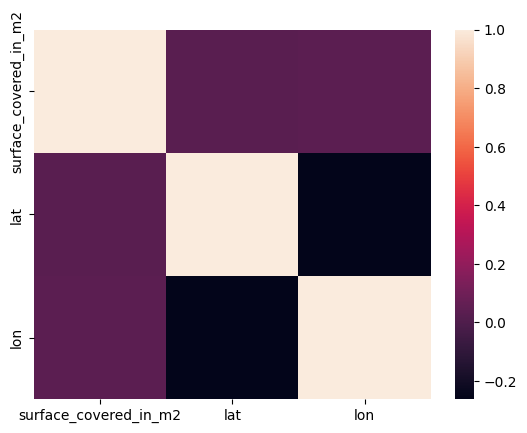

In [19]:
# The next step is plot my heatmap using Seaborn
sns.heatmap(corr);

In [20]:
# From my heatmap, I need to drop the columns with multicollinearity
# We go to our wrangle  function & drop them
# these are three features that are highly related. 


In [21]:
# Data is making decision for us. 

df.info()

# surface_area_total & rooms have large missing values

# surface_covered_in_m2 has less missing compared to the other two

# I will drop the two (that is surface_total_in_m2 and rooms) in my wrangle function

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB


In [22]:
# Check my work
assert len(df) == 6582, f"`df` has the wrong number of rows: {len(df)}"
assert df.shape[1] == 5, f"`df` has the wrong number of columns: {df.shape[1]}"
df.head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,215000.00,35.0,-34.588993,-58.400133,Recoleta
1,341550.00,90.0,-34.588044,-58.398066,Recoleta
2,91156.62,33.0,-34.623320,-58.397461,Monserrat
3,105000.00,33.0,-34.553897,-58.451939,Belgrano
4,89681.00,39.0,-34.628813,-58.472230,Villa del Parque


Now, I am done  with `EDA`

The next step is `Split Data`

Create your feature matrix `X_train` and target vector `y_train`. Your target is "price_aprox_usd". Your features should be all the columns that remain in the DataFrame you cleaned above.

In [23]:
target = "price_aprox_usd"
y_train = df[target]
feature = ["surface_covered_in_m2", "lat", "lon", "neighborhood"]
X_train = df[feature]

In [24]:
# Check my work
assert X_train.shape == (6582, 4), f"`X_train` is the wrong size: {X_train.shape}."
assert y_train.shape == (6582,), f"`y_train` is the wrong size: {y_train.shape}."

Then the next step is `Build Model`

1. `Baseline`

In [25]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)

 Calculate the baseline mean absolute error for your model.

In [26]:

print("Mean apt price:", y_mean)

print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 132383.83701458524
Baseline MAE: 44860.10834274133


2. `Iterate`

Create a pipeline named `model` that contains a `OneHotEncoder`, `SimpleImputer`, and `Ridge predictor`.

In [27]:
model = make_pipeline(
    OneHotEncoder(),
    SimpleImputer(),
    Ridge()
)

In [28]:
# Then let's fit our model
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder', OneHotEncoder(cols=['neighborhood'])),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [29]:
# Check my work
check_is_fitted(model[-1])

3. `Evaluate`

Calculate the training mean absolute error for your predictions as compared to the true targets in y_train.

In [30]:
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 24207.10719033019


The final step is to `Communicate Results`

Create a function `make_prediction` that takes four arguments (area, lat, lon, and neighborhood) and returns your model's prediction for an apartment price.

In [31]:
def make_prediction(area, lat, lon, neighborhood):
    data = {
        "surface_covered_in_m2": area,
        "lat": lat,
        "lon": lon,
        "neighborhood": neighborhood
    }
    
    df = pd.DataFrame(data, index=[0])
    
    prediction = model.predict(df).round(2)[0]
    
    return f"Predicted apartment price: ${prediction}"

In [32]:
# Trying an example to see how my model predicts
make_prediction(110, -34.60, -58.46, "Villa Crespo")

# This is referred to as prediction function

'Predicted apartment price: $250775.11'

Next, I want to use `Interactive Dashboard` (Minimum Viable Product). This is another type of deplyment that I will use

Add your make_prediction to the interact widget below, run the cell, and then adjust the widget to see how predicted apartment price changes.

Create an interact function in Jupyter Widgets.

In [33]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=53, description='area', max=101, min=30), FloatSlider(value=-34.59890626…

I can hover around my interactive dashboard to determine how latitude, area,longitude, latitude and neighborhood determine house prices in Buenos Aires